In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [6]:
import os

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [12]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [14]:
""" #viewing some sample from the dataset.
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    """

' #viewing some sample from the dataset.\nclass_names = train_dataset.class_names\n\nplt.figure(figsize=(10, 10))\nfor images, labels in train_dataset.take(1):\n  for i in range(3):\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(images[i].numpy().astype("uint8"))\n    plt.title(class_names[labels[i]])\n    plt.axis("off")\n    '

In [15]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [20]:
""" result of data augmentation
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
    """

" result of data augmentation\nfor image, _ in train_dataset.take(1):\n  plt.figure(figsize=(10, 10))\n  first_image = image[0]\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n    plt.imshow(augmented_image[0] / 255)\n    plt.axis('off')\n    "

In [31]:
#preprocessing specific to resnet.
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [24]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94781440/94765736 [==============================] - 2s 0us/step


In [25]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [26]:
#output of the base model.
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [27]:
base_model.trainable = False

In [28]:
#convert the features to a single 2048-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [29]:
#Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [32]:
"""Build a model by chaining together the data augmentation, rescaling, 
base_model and feature extractor layers using the Keras Functional API. """
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [35]:
len(model.trainable_variables)

2

In [36]:
#performance before training.
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 67s 2s/step - loss: 0.9300 - accuracy: 0.4901


In [37]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.93
initial accuracy: 0.49


In [38]:
#training the model for 10 epochs.
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 240s 4s/step - loss: 0.7622 - accuracy: 0.6020 - val_loss: 0.4639 - val_accuracy: 0.7525
Epoch 2/10
63/63 [==============================] - 235s 4s/step - loss: 0.4891 - accuracy: 0.7580 - val_loss: 0.2733 - val_accuracy: 0.8812
Epoch 3/10
63/63 [==============================] - 238s 4s/step - loss: 0.3464 - accuracy: 0.8325 - val_loss: 0.1957 - val_accuracy: 0.9270
Epoch 4/10
63/63 [==============================] - 235s 4s/step - loss: 0.2953 - accuracy: 0.8735 - val_loss: 0.1600 - val_accuracy: 0.9505
Epoch 5/10
63/63 [==============================] - 234s 4s/step - loss: 0.2639 - accuracy: 0.8850 - val_loss: 0.1293 - val_accuracy: 0.9604
Epoch 6/10
63/63 [==============================] - 238s 4s/step - loss: 0.2131 - accuracy: 0.9110 - val_loss: 0.1152 - val_accuracy: 0.9666
Epoch 7/10
63/63 [==============================] - 233s 4s/step - loss: 0.2117 - accuracy: 0.9110 - val_loss: 0.1040 - val_accuracy: 0.9666
Epoch 8/10
63

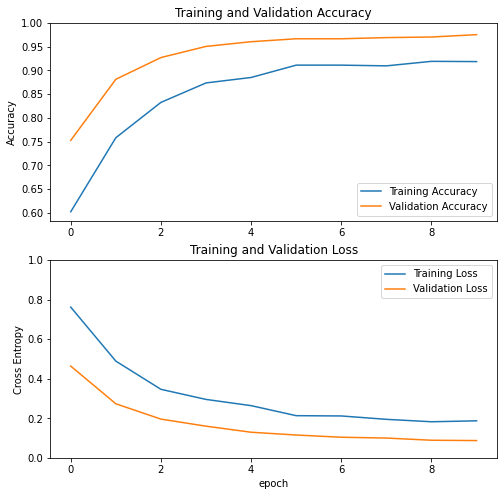

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()